# Time Series

## Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Ścieżka do datasetu na Google Drive
dataset_path = '/content/drive/MyDrive/Machine_Learning/time_series_datasets/jena_climate_2009_2016.csv'

Mounted at /content/drive


In [ ]:
data = open(dataset_path).read()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [ ]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values
print(float_data.shape)

(420451, 14)


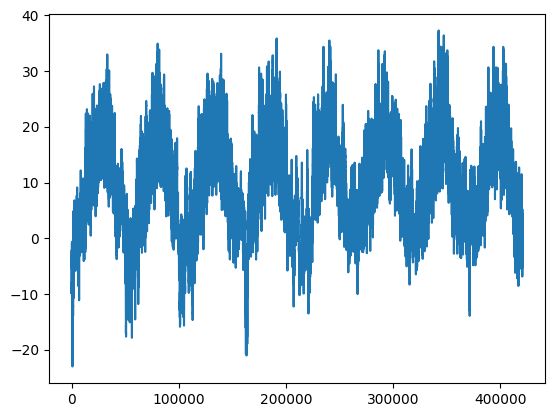

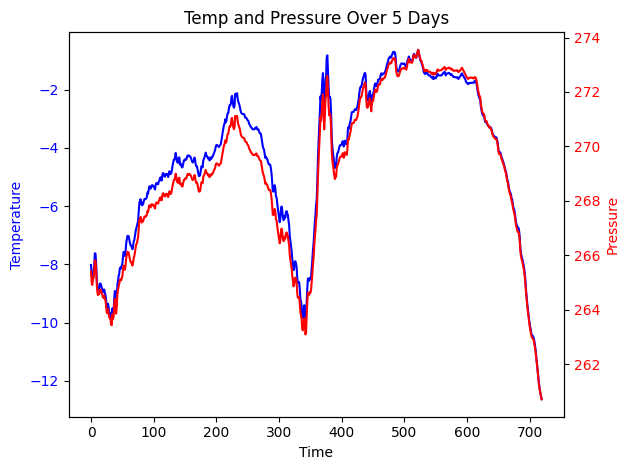

In [ ]:
import matplotlib.pyplot as plt

temp = float_data[:, 1]

#TODO: Plot whole temperature series, notice yearly trends
plt.plot(range(len(temp)), temp)
plt.show()

#TODO: Plot the first few days
# Dane do wykresu
few_days = float_data[:720, 1]
few_days_pressure = float_data[:720, 2]

fig, ax1 = plt.subplots()
ax1.plot(range(len(few_days)), few_days, label="Temperature", color="blue")
ax1.set_xlabel("Time")
ax1.set_ylabel("Temperature", color="blue")
ax1.tick_params(axis='y', labelcolor="blue")

ax2 = ax1.twinx()
ax2.plot(range(len(few_days_pressure)), few_days_pressure, label="Pressure", color="red")
ax2.set_ylabel("Pressure", color="red")
ax2.tick_params(axis='y', labelcolor="red")
plt.title("Temp and Pressure Over 5 Days")
fig.tight_layout()
plt.show()

### train set normalization

In [ ]:
train_data = float_data[:200000]

train_mean = train_data.mean(axis=0)
train_std = train_data.std(axis=0)

float_data = (float_data - train_mean) / train_std

## Set up data generators

In [ ]:
# generator function used to feed the training, validation and test data

def generator(data, lookback, delay, min_index, max_index,
                shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                    min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                            lookback // step,
                            data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [ ]:
#TODO Define lookback, step, delay and batch size variable
lookback = 720
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                        lookback=lookback,
                        delay=delay,
                        min_index=0,
                        max_index=200000,
                        shuffle=True,
                        step=step,
                        batch_size=batch_size)

#TODO: Set a validation generator similar to train generator. Use next 100000 samples (max index from 200,000 to 300,000). Do not shuftle the data:

val_gen = generator(float_data,
                        lookback=lookback,
                        delay=delay,
                        min_index=200001,
                        max_index=300000,
                        shuffle=False,
                        step=step,
                        batch_size=batch_size)

#TODO: Set a validation generator similar to a train generator. Use further next 100000 samples (max index from 300,000 onwards). Do not shuffle the data:

test_gen = generator(float_data,
                        lookback=lookback,
                        delay=delay,
                        min_index=300001,
                        max_index=None,
                        shuffle=False,
                        step=step,
                        batch_size=batch_size)

## Network training

### Basic approach

In [ ]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

# Number of steps to draw from val_gen to see the entire validation set
val_steps = (300000 - 200001 - lookback)//batch_size

#TODO: Train the network for about 20 epochs
history = model.fit(train_gen, steps_per_epoch=500, epochs=20, validation_data=val_gen, validation_steps=val_steps)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 1.0252 - val_loss: 0.3643
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.3262 - val_loss: 0.2906
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.2859 - val_loss: 0.2852
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.2709 - val_loss: 0.2872
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.2588 - val_loss: 0.2948
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.2530 - val_loss: 0.2900
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.2473 - val_loss: 0.2982
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.2433 - val_loss: 0.3540
Epoch 9/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.2411 - val_loss: 0.3195
Epoch 10/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.2399 - val_loss: 0.3004
Epoch 11/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.2361 - val_loss: 0.2955
Epoch 12/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 

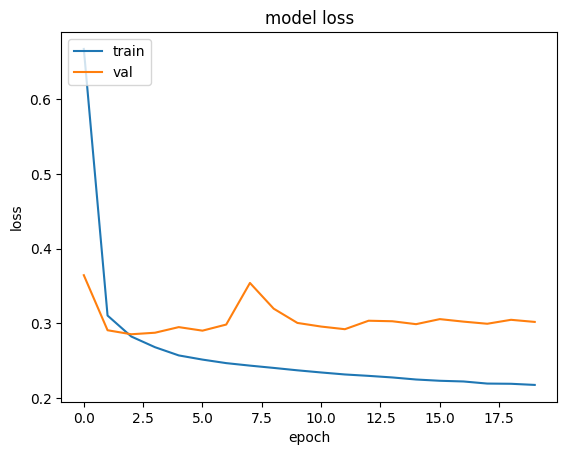

In [ ]:
#TODO: Plot the results
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### GRU layer

In [ ]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen, steps_per_epoch=500, epochs=20, validation_data=val_gen, validation_steps=val_steps)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.3137 - val_loss: 0.2754
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.2866 - val_loss: 0.2759
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.2791 - val_loss: 0.2612
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.2757 - val_loss: 0.2603
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.2731 - val_loss: 0.2620
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.2666 - val_loss: 0.2589
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.2621 - val_loss: 0.2615
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.2567 - val_loss: 0.2645
Epoch 9/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.2538 - val_loss: 0.2639
Epoch 10/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 0.2482 - val_loss: 0.2665
Epoch 11/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.2478 - val_loss: 0.2688
Epoch 12/20
500/500 ━━━━━━━━━━━━━━━━━

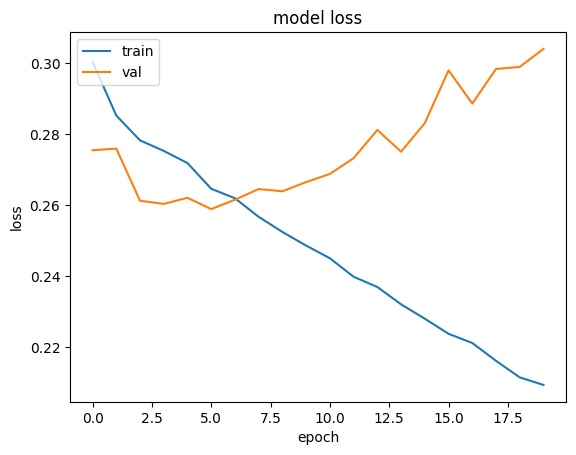

In [ ]:
#TODO: Plot the results
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Stacked

In [ ]:
model = Sequential()
model.add(layers.GRU(32, return_sequences=True, input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(32, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(layers.GRU(32))

model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen, steps_per_epoch=500, epochs=40, validation_data=val_gen, validation_steps=val_steps)

Epoch 1/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 189s 367ms/step - loss: 0.3851 - val_loss: 0.2770
Epoch 2/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 182s 365ms/step - loss: 0.3127 - val_loss: 0.2702
Epoch 3/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 182s 365ms/step - loss: 0.2990 - val_loss: 0.2663
Epoch 4/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 183s 366ms/step - loss: 0.2956 - val_loss: 0.2655
Epoch 5/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 182s 365ms/step - loss: 0.2890 - val_loss: 0.2625
Epoch 6/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 185s 370ms/step - loss: 0.2822 - val_loss: 0.2633
Epoch 7/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 185s 370ms/step - loss: 0.2779 - val_loss: 0.2728
Epoch 8/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 183s 366ms/step - loss: 0.2751 - val_loss: 0.2678
Epoch 9/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 183s 367ms/step - loss: 0.2839 - val_loss: 0.2686
Epoch 10/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 185s 369ms/step - loss: 0.3029 - val_loss: 0.2652
Epoch 11/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 185s 370ms/step - loss: 0.2787 - val_loss: 0.2653
Epoch 12

KeyboardInterrupt: 

In [ ]:
# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Stacked GRU Layers with Dropout Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

### Bidirectional GRU layer

In [ ]:
model = Sequential()
model.add(layers.Bidirectional(layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen, steps_per_epoch=500, epochs=40, validation_data=val_gen, validation_steps=val_steps)

Epoch 1/40


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - loss: 0.3089 - val_loss: 0.2740
Epoch 2/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 0.2786 - val_loss: 0.2795
Epoch 3/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.2704 - val_loss: 0.2731
Epoch 4/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.2653 - val_loss: 0.2672
Epoch 5/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.2613 - val_loss: 0.2791
Epoch 6/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - loss: 0.2552 - val_loss: 0.2813
Epoch 7/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.2484 - val_loss: 0.2733
Epoch 8/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.2429 - val_loss: 0.2769
Epoch 9/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.2382 - val_loss: 0.2793
Epoch 10/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.2315 - val_loss: 0.2831
Epoch 11/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - loss: 0.2245 - val_loss: 0.2856
Epoch 12/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 

KeyboardInterrupt: 

In [ ]:
# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Stacked GRU Layers with Dropout Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

### Conv1D layers

In [ ]:
model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GRU(32))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen, steps_per_epoch=500, epochs=20, validation_data=val_gen, validation_steps=val_steps)

In [ ]:
# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Stacked GRU Layers with Dropout Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()